# Crime Analytics: Theft increases at night in Seattle (Summer 2014)

*Ravi Ancil Persad*

## Introduction & Data overview

Open source crime data from the Seattle Police Department can be accessed at the [Seattle Data Portal](https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Police-Report-Incident/7ais-f98f). This database comprises of recorded incidents from police reports taken by officers. Details such as the offense type, the name of the zone/location where an offense occurred, in addition to geospatial details of the incident location are all stored as variables in .csv file format. There are 32,779 row entries of incidents.

In this entry, I will analyze the crime incidents for the city of Seattle in Summer 2014 (June, July and August 2014). More specifically, I will explore and answer the following question pertaining to criminal offenses:

- ***How do incidents vary by time of day?***


I will support my analysis with multiple visualizations, a vital aspect of exploratory data analysis. Please note that I have made all my Python code available for reproducing this analysis at the following [Github repository](https://github.com/RaviAnalytics/Crime_Analytics_Seattle_Ravi/blob/master/RaviCrimeAnalytics.ipynb).To further support reproducibility, within this document you will see a '**Show Code**' button. The button can be used to optionally toggle the source code visibility for the respective visualizations I generate during the analysis.

## Visualization 1: Timeseries of Crime incidents by time of day

In this section, I analyze how the trend of offenses progress during the full 24 hours for each day in the dataset. In the time series visualization below, we can observe that as the day progresses there is a general increase in crime frequency. In particular, there seems to be an a ***high crime count during the evening/night*** as we move towards midnight (0:00/24:00). This is my ***primary finding***. Afterwards, it is noticeable from the visualization that the number of incidents generally tapers off at a lower rate till 5am.

In [1]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in data
df = pd.read_csv("seattle_incidents_summer_2014.csv",low_memory=False,parse_dates=['Occurred Date or Date Range Start', 'Occurred Date Range End'],
                    infer_datetime_format=True)

In [3]:
# create additional columns 'date','hour', month', etc for the dataframe
ind_Summer = pd.DatetimeIndex(df['Occurred Date or Date Range Start'])
df['date'] = ind_Summer.date.astype('datetime64')
df['hour'] = ind_Summer.hour
df['month'] = ind_Summer.month
df['dayofweek'] = ind_Summer.dayofweek
df['day'] = ind_Summer.day


In [4]:
# count offenses per hour for each day
by_each_day_by_each_hour_Summer = df.pivot_table('RMS CDW ID', aggfunc='count',index=['month','day','hour'])
by_each_day_by_each_hour_Summer

df_Summer = (pd.DataFrame(by_each_day_by_each_hour_Summer)).reset_index()
df_Summer.rename(columns={'RMS CDW ID': 'Offense_count'}, inplace=True)

# Group offense count by month/day (row index) and hourly basis (columns indexed from 0 to 24 hrs)
daily_per_hr_Summer =  df_Summer.pivot_table(['Offense_count'],index=[df_Summer.month,df_Summer.day],columns = df_Summer.hour)

# fill in nan (non-data entries) with zero
df2_Summer = daily_per_hr_Summer.fillna(0)


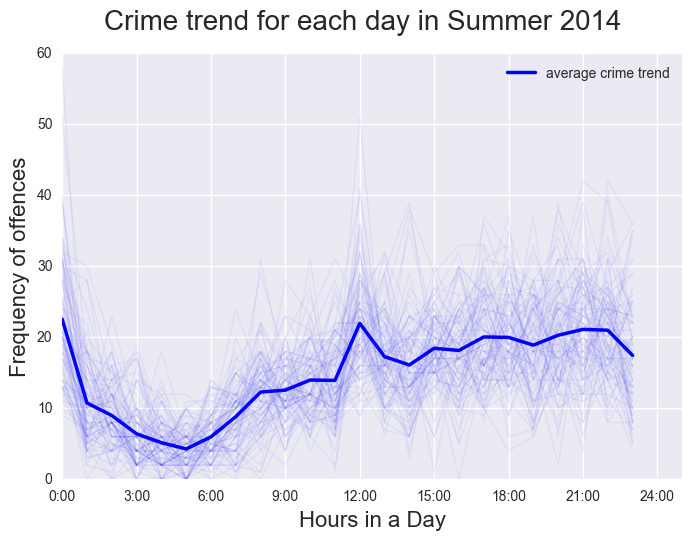

In [5]:
# generate figure 1
from matplotlib.dates import DateFormatter, MinuteLocator
fmt = plt.FuncFormatter(lambda x, *args: '{0}:00'.format(int(x)))
plot1=plt.plot(range(24),df2_Summer.values.T,'b', lw=1 ,alpha=0.05);
plot2=plt.plot(range(24),df2_Summer.mean(0),'b', lw=2.5, label='average crime trend');
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3))
plt.gca().xaxis.set_major_formatter( fmt )
plt.suptitle('Crime trend for each day in Summer 2014', fontsize=20)
plt.xlabel('Hours in a Day', fontsize=16)
plt.ylabel('Frequency of offences', fontsize=16)
plt.legend()
plt.show()

## Visualization 2: Histogram of Crime incidents during peak hours (6pm-12midnight)

To further investigate how crime incidents varies throughout the day, I will now visualize how the different types of offenses vary during high crime periods (i.e. peak hours from 6pm to 12am midnight). TThe dataset, as expected was raw and not clean. To generate this visualization, some data munging was performed. For instance, some offenses which fall into the same category (e.g., 'PROSTITUTION LOITERING' and 'PROSTITUTION') were grouped and their respective counts were aggregated.

From the histogram below, we see that ***theft*** is the most prominent offense type during the peak hours with an approximate frequency count above 5000 for the summer of 2014 in Seattle. From this we can ***refine my primary finding*** and now say that the ***there is a high crime count at night with theft incidents being the most common***.

In [6]:
# Count crimes by type

df.groupby(['Offense Type']).groups.keys()

# create an empty column which we will fill int he next step
df["CrimeCount"] = ""
df2=df.groupby(['Offense Type','hour']).agg(['count'])
df3=df2['CrimeCount'].reset_index()
# remove hyphens and parts of string in 'Offense type' column after hyphens 
df3['Offense Type'] = df3['Offense Type'].apply(lambda x: x.split('-')[0])

# offenses grouped with their total count - a better way with reset index
df4=df3.groupby(['Offense Type','hour']).sum()

df4_2=df4.reset_index()
df4_2

# keep offenses after 6pm (or 1800hrs) till 12 midnight (000hrs)
df4_3 = df4_2[(df4_2['hour'] >= 18) | (df4_2['hour'] == 0)]
df4_3

total_per_offense_peak_hrs = df4_3.groupby(['Offense Type']).sum()
total_per_offense_peak_hrs

# cleaning row names for Offense Types : We group 'property' related offenses,'prositution' related, etc
total_per_offense_peak_hrs = total_per_offense_peak_hrs.rename(index={'PROPERTY DAMAGE ': 'PROPERTY','PROPERTY DAMAGE': 'PROPERTY',
                                        'PROPERTY FOUND': 'PROPERTY','PROPERTY LOST':'PROPERTY','PROPERTY LOST ':'PROPERTY',
                                         'PROPERTY STOLEN':'PROPERTY','PROSTITUTION LOITERING':'PROSTITUTION',
                                        'PROSTITUTION PATRONIZING':'PROSTITUTION','THEFT OF SERVICES':'THEFT',
                                        'WARRARR':'WARRANT'})
total_per_offense_peak_hrs
total_per_offense_peak_hrs_cleaned = total_per_offense_peak_hrs.reset_index()
total_per_offense_peak_hrs_cleaned
# get the type for each column in dataframe
total_per_offense_peak_hrs_cleaned.dtypes

# drop the row containing '[INC' , this variable only has 1 count, and with lack of domain knowledge
# as to what this offense type is based on the acroymn, I regard it as inconsequential.
total_per_offense_peak_hrs_cleaned=total_per_offense_peak_hrs_cleaned.drop(total_per_offense_peak_hrs_cleaned.index[[46]])

In [7]:
total_per_offense_peak_hrs_cleaned2 = total_per_offense_peak_hrs_cleaned.set_index('Offense Type')
total_per_offense_peak_hrs_cleaned2

total_per_offense_peak_hrs_cleaned3 = total_per_offense_peak_hrs_cleaned2.reset_index().groupby('Offense Type').sum()
total_per_offense_peak_hrs_cleaned3.drop(['hour'],axis=1);


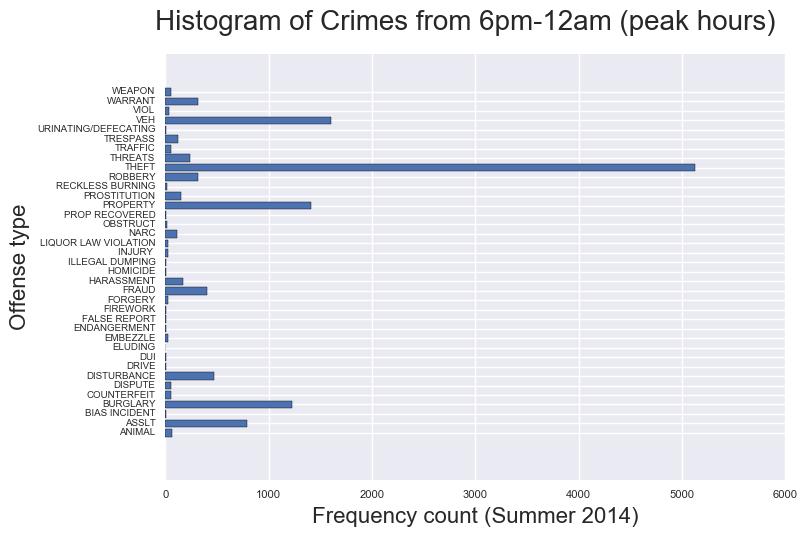

In [8]:
# generate figure 2
#-- first make the x-axis labels as a tuple ----
objects = tuple(total_per_offense_peak_hrs_cleaned3.index)
x_pos = np.arange(len(objects))


total_per_offense_peak_hrs_cleaned4 = total_per_offense_peak_hrs_cleaned3.reset_index()
y_pos = list(total_per_offense_peak_hrs_cleaned4['count'])

sizex=8
sizey=7
plt.barh(x_pos, y_pos, align='center');
plt.yticks(x_pos, objects, rotation=0);
# plt.rc('ytick', labelsize=size)  # fontsize of the tick labels
plt.xticks(fontsize=sizex)
plt.yticks(fontsize=sizey)
plt.suptitle('Histogram of Crimes from 6pm-12am (peak hours)', fontsize=20)
plt.xlabel('Frequency count (Summer 2014)', fontsize=16)
plt.ylabel('Offense type', fontsize=16)
plt.show();

## Visualization 3: Histogram of Daytime/Night-time crime count for each summer month

To further support my primary finding that most crime occurs at night, I'll generate a histogram of crime incidents for each month (June, July and August) of summer 2014 in Seattle.

From the histogram below, we see that for all 3 months there is a higher crime count at night-time for each month during summer 2014. This is further supported by the respective daytime and night-time mean counts shown by the dashed lines, with the night-time line being above the daytime line.

In [9]:
# subset data for each month: June, July, August
df_June = df.loc[df['month'] == 6]
df_July = df.loc[df['month'] == 7]
df_August = df.loc[df['month'] == 8]

In [10]:
# For each month, we will look daily trends for the total amount of offences. Additionally we will visually analyze the total 
# offenses for daytime periods(i.e., 8am-4pm) and for nighttime periods (i.e., 5pm-7am)

# June analysis
#========================== Daytime ===========================================================

# subset dataframe with Daytime Offenses (8am-4pm)
df_June_DayTime = df_June.loc[(df_June['hour'] > 7) & (df_June['hour'] < 17)]

# Sum the total offense count for June/daytime 2014
Total_offenses_June_DayTime =  len(df_June_DayTime['Offense Type'])

#=========================== Nightime ==========================================================

# subset dataframe with Nightime Offenses (5pm-7am)
df_June_NightTime = df_June.loc[(df_June['hour'] > 16) | (df_June['hour'] < 8)]

# Sum the total offense count for June/nighttime 2014
Total_offenses_June_NightTime =  len(df_June_NightTime['Offense Type'])


In [11]:
# July Analysis
#========================== Daytime ===========================================================

# subset dataframe with Daytime Offenses (8am-4pm)
df_July_DayTime = df_July.loc[(df_July['hour'] > 7) & (df_July['hour'] < 17)]

# Sum the total offense count for July/daytime 2014
Total_offenses_July_DayTime =  len(df_July_DayTime['Offense Type'])

#=========================== Nightime ==========================================================

# subset dataframe with Nightime Offenses (5pm-7am)
df_July_NightTime = df_July.loc[(df_July['hour'] > 16) | (df_July['hour'] < 8)]

# Sum the total offense count for July/nighttime 2014
Total_offenses_July_NightTime =  len(df_July_NightTime['Offense Type'])

In [12]:
# August Analysis
#========================== Daytime ===========================================================

# subset dataframe with Daytime Offenses (8am-4pm)
df_August_DayTime = df_August.loc[(df_August['hour'] > 7) & (df_August['hour'] < 17)]

# Sum the total offense count for August/daytime 2014
Total_offenses_August_DayTime =  len(df_August_DayTime['Offense Type'])

#=========================== Nightime ==========================================================

# subset dataframe with Nightime Offenses (5pm-7am)
df_August_NightTime = df_August.loc[(df_August['hour'] > 16) | (df_August['hour'] < 8)]

# Sum the total offense count for August/nighttime 2014
Total_offenses_August_NightTime =  len(df_August_NightTime['Offense Type'])

In [13]:
Offenses_daytime = (Total_offenses_June_DayTime,Total_offenses_July_DayTime,Total_offenses_August_DayTime)
Offenses_nighttime = (Total_offenses_June_NightTime,Total_offenses_July_NightTime,Total_offenses_August_NightTime)

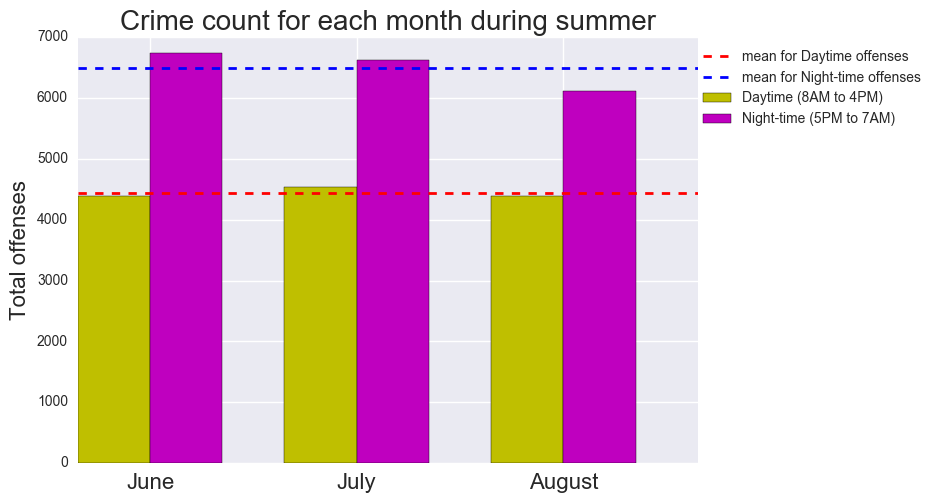

In [14]:
Num_of_months_in_summer = len(list(df['month'].unique()))


ind = np.arange(Num_of_months_in_summer)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(ind, Offenses_daytime, width, color='y')
rects2 = ax.bar(ind + width, Offenses_nighttime, width, color='m')


# add some text for labels, title and axes ticks
ax.set_ylabel('Total offenses', fontsize=16)
ax.set_title('Crime count for each month during summer', fontsize=20)
ax.set_xticks(ind + width)
ax.set_xticklabels(('June', 'July', 'August'), fontsize=16)
ax.axhline(np.mean(Offenses_daytime), color='red', linewidth=2, linestyle = 'dashed')
ax.axhline(np.mean(Offenses_nighttime), color='blue', linewidth=2, linestyle = 'dashed')
ax.legend(('mean for Daytime offenses','mean for Night-time offenses','Daytime (8AM to 4PM)', 'Night-time (5PM to 7AM)'), bbox_to_anchor=[1.38, 1]);


## Visualization 4: Geospatial distribution of theft incidents for different zones in Seattle

***My primary finding that most crime occurs at night and theft is the most prominent offense type at night ***. In my final visualization, it will interesting to see how theft varies in various regions/zones/beats across Seattle during Summer 2014. To identify regions where thefts are prominent, I use a spatial representation by illustrating the distribution of thefts overlayed on a an OpenStreetMap of Seattle. Since theft incidents are so common and are considered to be relatively serious incidents, I will show the distribution of theft for the entire of Summer 2014 (both day and night time theft incidents). 

From the .csv file, each incident has an associated latitude and longitude coordinate. Additionally, each incident also has an associated zone/beat, which are used by the police precinct to identify the region in Seattle where the crime occurred. Using this information, a theft distribution map can be generated. Firstly, I filtered the original dataframe to retain only theft incidents. Then, I aggregated the theft counts for each zone/beat in Seattle. There are 51 zones/beats in Seattle. A nice visualization of the zones/beats provided by the Seattle Police Department can be found [here](http://www.seattle.gov/police/tweets/).

To generate the visualization, an overlay of the zones/beats in Seattle must be found. Typically, this is done using a shapefile which has to be converted to geojson format for web visualization. A direct open-source geojson file with the zones/beats of Seattle was found at this [website](https://raw.githubusercontent.com/openseattle/seattle-boundaries/master/data/spd-beats.geojson). Using the geojson file, I overlayed a choropleth map over Seattle in OpenStreetMap showing the theft rate across different zones.

A map such as this can provide valuable insights for the relevant crime-prevention authorites in Seattle. From the map, we see that the ***red regions*** which indicate **high theft incidents** occur in several places, namely: ***University District, Phinney Ridge, Fremont and Belltown***.

In [15]:
# definition of the boundaries in the map
district_geo = r'sfpddistricts.geojson'

# remove rows from df with 'nan' and '99' in the 'Zone/Beat' column
df.head()
df.dtypes
dfa = df[df['Zone/Beat'].str.contains(" ") == False] # remove missing (nan) data
dfb = dfa[dfa['Zone/Beat'].str.contains("99") == False] # remove 99
dfb['Zone/Beat'].unique()

# remove hyphens and parts of string in 'Offense type' column after hyphens 
dfb['Offense Type'] = dfb['Offense Type'].apply(lambda x: x.split('-')[0])

# keep rows in dataframe with the word "Theft"
dfc = dfb[dfb['Offense Type'].str.contains("THEFT")]

# now we need to count the thefts in each of the Zones/Beats across Seattle:
dfd = dfc.pivot_table('Offense Type', aggfunc='count',index=['Zone/Beat'])
dfd = pd.DataFrame(dfd)
dfd.rename(columns={'Offense Type': 'Theft_count'}, inplace=True) # renaming column in dataframe
del dfd.index.name

In [41]:
import folium
import pandas as pd
import os
from IPython.display import HTML
from IPython.core.display import HTML
import json
state_geo2 = r'spd-beats.geojson'
SEATTLE_COORDINATES = (47.64602, -122.3321)

dfd2 =dfd
dfd2.to_json('theft2.json')
dfd2 = dfd2.reset_index()
dfd2.columns = ['name','Number']
dfd2

#Let Folium determine the scale
map3 = folium.Map(location=SEATTLE_COORDINATES, zoom_start=12)
map3.geo_json(geo_path=state_geo2, data_out = 'theft2.json', data=dfd2,
             columns=['name', 'Number'],
             key_on='feature.properties.name',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.5,
             legend_name='THEFT RATE ACROSS DIFFERENT ZONES IN SEATTLE')
def inline(m, width, height):
    """Returns an embedded iframe of a folium.map."""
    m._build_map()
    src = m.HTML.replace('"', '&quot;')
    style = "width: {}px; height: {}px".format(width, height)
    return '<iframe srcdoc="{}" style="{}"; border: none"></iframe>'.format(src, style)

html = inline(map3, 900, 500)
for name, data in map3.json_data.items():
    html = html.replace('d3.json, ' + repr(name), 'function(callback){callback(null, JSON.parse('+ repr(json.dumps(data).replace('"', '&quot;')) + '))}')
HTML(html)

## Conclusion

In summarizing, analysis was performed to observe crime in Seattle during the summer of 2014. The main question at hand was : How does crime vary by time of day? Using multiple visualizations, it was seen that the majority of crime occurs at night with the most popular offense being theft. From a spatial perspective via OpenStreetMap, we also saw that theft is fairly high and low depending upon the zones/beats across Seattle. 

A lot more can be done to further investigate crime patterns in Seattle. However, we have seen that analytics via visualization is very critical in understanding these patterns.